# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [7]:
# Alternative WITHOUT FOR
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

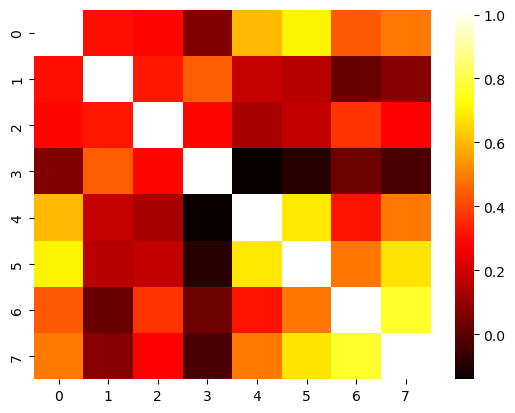

In [9]:
# Preliminary questions
%matplotlib inline
autocov = np.cov(M_train[:,0:8].T)
sns.heatmap(autocov, cmap='hot')
plt.show()

D'après la matrice d'autocovariance, nous pouvons remarquer que la majorité des attributs sont peu corrélés entre eux. Nous pouvons induire que l'augmenté (X_tilde qui sera en réalité appelé X_train) sera de rang plein et donc qu'une regression linéaire sera possible.

Nous pouvons de plus calculer la matrice de covariance entre les attributs et la cible.

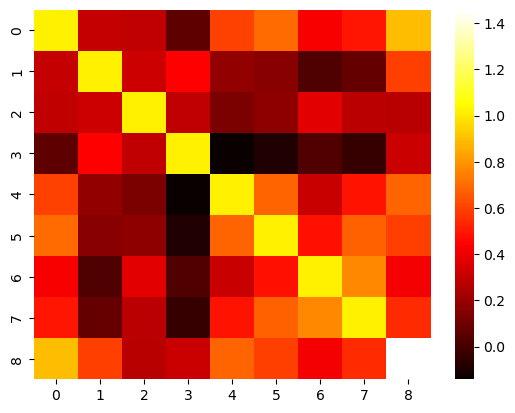

In [10]:
%matplotlib inline
autocov_cible = np.cov(np.concatenate([M_train[:,0:8], np.array([data_train[:,8]]).T], axis=1).T)
sns.heatmap(autocov_cible, cmap='hot')
plt.show()

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

### Construction de X_train

In [11]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test), axis=1) 
# don't forget the 1st column of ones and normalization !

In [12]:
X_train = np.concatenate((np.ones((M_train.shape[0],1)), M_train), axis=1) 
t_train = data_train[:,8]

In [13]:
print(f"La matrice X_train est de rang {np.linalg.matrix_rank(X_train)}")

La matrice X_train est de rang 9


On remarque de plus que, comme prévu,  X_train est de rang plein, donc §X_train^T X_train§ définie positive, donc inversible : La regression linéaire est bien possible.

### Calcul du vecteur de regression

In [14]:
beta_hat = np.dot(np.dot(linalg.inv(np.dot(X_train.T,X_train)), X_train.T),t_train)

In [15]:
print(f"Le coefficient beta_hat[0] vaut {np.round(beta_hat[0],3)}, qui correspond au biais du modèle de regression linéaire. Les variations de la prédiction vont se faire autour de cette valeur.")

Le coefficient beta_hat[0] vaut 2.452, qui correspond au biais du modèle de regression linéaire. Les variations de la prédiction vont se faire autour de cette valeur.


### Estimation de l'erreur

In [16]:
pred_error = np.dot((t_test - np.dot(X_test, beta_hat)).T,(t_test - np.dot(X_test, beta_hat)))
print(f"On estime l'erreur quadratique E_LS pour les données de test à {np.round(pred_error,3)}.")

On estime l'erreur quadratique E_LS pour les données de test à 15.638.


## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

### Calcul des Z-scores

In [17]:
# Exercise 2
sigma = np.sqrt((1/(M_train.shape[0]-8-1)) * sum([((t_train[n]-np.dot(X_train[n],beta_hat))**2) for n in range(M_train.shape[0])]))

z_scores = np.zeros(beta_hat.shape[0]-1)
for j in range(1,beta_hat.shape[0]):
    z_scores[j-1] = beta_hat[j] / (sigma*sqrt(np.diag(linalg.inv(X_train.T.dot(X_train)), k=0)[j]))

print(z_scores)
np.sort(np.abs(z_scores))[-1:0:-1]

[ 5.36629046  2.75078939 -1.39590898  2.05584563  2.46925518 -1.86691264
 -0.14668121  1.73783972]


array([5.36629046, 2.75078939, 2.46925518, 2.05584563, 1.86691264,
       1.73783972, 1.39590898])

D'après les valeurs de Z-score pour les différents attributs, on remarque que seuls 4 d'entre eux permettent de vérifier la "null-hypothesis" de la composante de beta-hat. Les attributs correspondants sont les attributs suivants donnés par "indice : nom" :
- 0 : lcalvol
- 1 : lweight
- 3 : lbph
- 4 : svi

On estime par la suite le nouveau vecteur de régression en tenant compte simplement des attributs gardés, c'est à dire en mettant artificiellement à zéros les coefficients dont le Z-score n'était pas supérieur à 2.

In [18]:
new_M_train = np.concatenate((M_train[:,0:2],M_train[:,3:5]), axis=1)
new_M_test = np.concatenate((M_test[:,0:2],M_test[:,3:5]), axis=1)

new_X_train = np.concatenate((np.ones((new_M_train.shape[0],1)), new_M_train), axis=1) 
new_X_test = np.concatenate((np.ones((new_M_test.shape[0],1)), new_M_test), axis=1) 

beta_hat_coeffs = np.dot(np.dot(linalg.inv(np.dot(new_X_train.T,new_X_train)), new_X_train.T),t_train)
new_beta_hat = np.zeros(X_train.shape[1])
new_beta_hat[0] = beta_hat_coeffs[0]
new_beta_hat[1] = beta_hat_coeffs[1]
new_beta_hat[2] = beta_hat_coeffs[2]
new_beta_hat[4] = beta_hat_coeffs[3]
new_beta_hat[5] = beta_hat_coeffs[4]

print(f"Le nouveau vecteur de régression vaut maintenant {new_beta_hat}")
print(f"Le coefficient beta_hat[0] vaut toujours {np.round(new_beta_hat[0],3)}.")

new_pred_error = np.dot((t_test - np.dot(X_test, new_beta_hat)).T,(t_test - np.dot(X_test, new_beta_hat)))
print(f"On estime la nouvelle erreur quadratique E_LS pour les données de test à {np.round(new_pred_error,3)}")

Le nouveau vecteur de régression vaut maintenant [2.45234509 0.62345    0.25488273 0.         0.20339287 0.2800554
 0.         0.         0.        ]
Le coefficient beta_hat[0] vaut toujours 2.452.
On estime la nouvelle erreur quadratique E_LS pour les données de test à 13.69


<u>Interprétation</u> : On constate  une erreur quadratique plus élevée sans réduction de dimension. Tout ce que l'on sait de la réduction de dimension est qu'elle réduit la variance mais augmente le biais. On sait également que l'erreur quadratique se décompose en un terme relatif aux bruits inhérent aux données, en un terme relatif au biais (au carré) et en un terme relatif à la variance. On ne pouvait pas prédire la valeur de la nouvelle erreur quadratique, tout ce que l'on peut dire est que dans cette dimension, on constate une plus faible erreur entre la prédiction et la valeur réelle. Nous pouvons dire que le modèle est plus fidèle à la réalité et plus pertinent pour faire de nouvelles prédictions que l'ancien. Il faudrait calculer un optimum global de l'erreur quadratique pour remonter à la sous-section optimale des attributs.

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

### Calcul du vecteur de régression

In [50]:
t_train = data_train[:,8]
t_test = data_test[:,8]
t0 = np.mean(t_train)
t_train_norm = t_train-t0
t_test_norm = t_test-t0

lbd = 2

N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 

def compute_beta_hat_reg(lbd):
    # lbd = lambda
    beta_hat_reg_no_bias = np.dot(np.dot(linalg.inv(lbd*np.identity(M_train[:,0:8].shape[1]) + np.dot(M_train[:,0:8].T,M_train[:,0:8])), M_train[:,0:8].T),t_train_norm)
    beta_hat_reg = np.concatenate((np.array([t0]).T, beta_hat_reg_no_bias), axis=0)
    return beta_hat_reg

beta_hat_reg_no_bias = np.dot(np.dot(linalg.inv(lbd*np.identity(M_train[:,0:8].shape[1]) + np.dot(M_train[:,0:8].T,M_train[:,0:8])), M_train[:,0:8].T),t_train_norm)
beta_hat_reg = compute_beta_hat_reg(lbd) # contient le biais
t_hat_reg = X_test.dot(beta_hat_reg) # prédiction

In [51]:
beta_hat_reg

array([ 2.45234509, -0.11720753,  0.08983946, -0.2999865 , -0.00842061,
        0.24485123, -0.14079899,  0.17830032, -0.05320873])

In [52]:
print(f"""Le nouveau vecteur de régression pour la "ridge regression" (avec lambda = 25) vaut :
{beta_hat_reg}.
On note que le biais vaut toujours {np.round(beta_hat_reg[0],3)}.""")

Le nouveau vecteur de régression pour la "ridge regression" (avec lambda = 25) vaut :
[ 2.45234509 -0.11720753  0.08983946 -0.2999865  -0.00842061  0.24485123
 -0.14079899  0.17830032 -0.05320873].
On note que le biais vaut toujours 2.452.


### Estimation de l'erreur prédictive

In [58]:
pred_error_ls = np.dot((t_test_norm - np.dot(M_test[:,0:8], beta_hat_reg_no_bias)).T,(t_test_norm - np.dot(M_test[:,0:8], beta_hat_reg_no_bias)))
pred_error_rr = pred_error_ls + lbd * np.dot(beta_hat_reg_no_bias.T,beta_hat_reg_no_bias)
print(f"On estime la nouvelle erreur quadratique E_RR pour les données de test à {np.round(pred_error_rr,3)}")
print(f"On estime la nouvelle erreur quadratique E_LS pour les données de test à {np.round(pred_error_ls,3)}")

On estime la nouvelle erreur quadratique E_RR pour les données de test à 32.868
On estime la nouvelle erreur quadratique E_LS pour les données de test à 32.416


In [23]:
beta_best = np.array([2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0])

pred_error_ls = np.dot((t_test - np.dot(X_test, beta_best)).T,(t_test - np.dot(X_test, beta_best)))
print(f"On estime l'erreur quadratique E_LS théoriquement minimale pour les données de test avec la méthode de sélection des attributs à {np.round(pred_error_ls,3)}")

On estime l'erreur quadratique E_LS théoriquement minimale pour les données de test avec la méthode de sélection des attributs à 14.811


<u>Interprétation</u> : On constate que l'on obtient une valeur d'erreur plus élevée dans le cas des moindres carrés régularisés (avec lambda = 25) que dans le cas des moindres carrés avec sélection des attributs. Toutefois, il faut noter qu'une vraie interprétation peut être faite seulement dans le cas où l'on teste la méthode des moindres carrés régularisés pour de nombreuses valeurs différentes de lambda. Si l'on parvient à obtenir (pour une valeur l de lambda) une erreur prédictive plus faible que celle donnée par beta_best pour la méthode de sélection d'attributs, on pourra en conclure que la méthode des moindres carrés régularisés permet une meilleure prédiction avec l = lambda que la méthode de sélection des attributs. 

**IMPORTANT** : Dans la partie 2, on a calculé une erreur de 14.771 lorsqu'on ne garde que les 2 premiers attributs et de 13.69 quand on en garde 4. Or, théoriquement, le meilleur beta pour la partie 2 est beta_best donné dans la partie 3. On constate pourtant que la valeur du biais n'est pas la même que celle trouvée à chaque fois : 2.477 != 2.452. Il y a donc un problème ici, est-ce notre valeur ou celle de l'énoncé qui est fausse ? Cela se répercute juste après dans la partie 3 car avec le beta_best on calcule une erreur LS théoriquement minimale de 14.811 qui est supérieure à celles trouvées avec nos valeurs pour 2 et 4 attributs... Il semblerait qu'il faille comparer nos résultats avec les autres groupes et discuter de ce beta_best avec le prof.

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [ ]:
from sklearn.utils import shuffle

# shuffling dataset (features and targets accordingly)
data_train = shuffle(data_train)

#t_train = data_train[:,8]
#t_test = data_test[:,8]

: 

In [ ]:
data_train

: 

In [76]:
lmax = 40
lambda_pos = arange(0,lmax+1)
N_test = 10

results = [0 for _ in range(len(lambda_pos))]
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))
for p in range(6):   # loop on test subsets
    # extraction of testset
    testset = data_train[arange(p*N_test,(p+1)*N_test),0:9]
    # extraction of trainset
    trainset = data_train[hstack((arange(p*N_test),arange((p+1)*N_test,data_train.shape[0]))),0:9]

    # normalizing trainset and testset (mean = 0, std = 1)

    normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
    M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
    moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
    sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

    M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

    # normalizing targets
    t0 = np.mean(t_train)
    t_train_norm = t_train-t0
    t_test_norm = t_test-t0

    for l in range(lambda_pos.shape[0]):
        # estimate beta_hat
        beta_hat_reg_no_bias = np.dot(np.dot(linalg.inv(lambda_pos[l]*np.identity(M_train.shape[1]) + np.dot(M_train.T,M_train)), M_train.T),t_train_norm)
        pred_error_ls = np.dot((t_test_norm - np.dot(M_test[:,0:8], beta_hat_reg_no_bias)).T,(t_test_norm - np.dot(M_test[:,0:8], beta_hat_reg_no_bias)))
        pred_error_rr = pred_error_ls + lambda_pos[l] * np.dot(beta_hat_reg_no_bias.T,beta_hat_reg_no_bias)
        erreur[p,l] = pred_error_rr
        results[l] += pred_error_rr

# average error for each lambda
results = [r/6 for r in results]
print(results)
lambda_opt = lambda_pos[results.index(min(results))]
print(f"Le lambda optimal trouvé par la cross-validation vaut {lambda_opt}.")

[15.638220165227992, 16.21206730567603, 16.732814645215488, 17.210689663635247, 17.653204217104047, 18.06601804541774, 18.453490365030323, 18.819043957447352, 19.165412398514544, 19.49481213724201, 19.809064901004778, 20.10968646213901, 20.397952129510003, 20.674945823221776, 20.94159736796058, 21.198711198403174, 21.446988714929805, 21.68704588318327, 21.91942722837302, 22.14461706652015, 22.363048596435604, 22.575111319649995, 22.78115714188756, 22.98150542627846, 23.17644720664482, 23.366248722860302, 23.55115440525542, 23.731389408332053, 23.907161773520134, 24.07866428480691, 24.24607606866209, 24.40956397993675, 24.569283807708345, 24.725381328915233, 24.877993232719316, 25.02724793458953, 25.173266295906597, 25.316162262293975, 25.456043431759554, 25.593011561991826, 25.727163024718973]
Le lambda optimal trouvé par la cross-validation vaut 0.


In [87]:
"""
Nouvelle version : J'ai modifier le M et le t qui doit être prit dans le nouveau dataset d'entrainement et de
"""

lmax = 40
lambda_pos = arange(0,lmax+1)
N_test = 10


results = [0 for _ in range(len(lambda_pos))]
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))
for p in range(6):   # loop on test subsets
    # extraction of testset
    testset = data_train[arange(p*N_test,(p+1)*N_test),0:9]
    t_testk = testset[:,8]
    # extraction of trainset
    trainset = data_train[hstack((arange(p*N_test),arange((p+1)*N_test,data_train.shape[0]))),0:9]
    t_traink = trainset[:,8]

    # normalizing trainset and testset (mean = 0, std = 1)

    normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
    M_traink = np.array( [ normalize(vec) for vec in trainset[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
    moyk = np.array( [ np.mean(vec) for vec in trainset[:,0:8].T ] )
    sigmak = np.array( [ np.std(vec, ddof=0) for vec in trainset[:,0:8].T ] )

    M_testk = np.array([ (testset[:,k]-moyk[k])/sigmak[k] for k in range(M_traink.shape[1]) ] ).T
    X_testk = np.concatenate((np.ones((N_test,1)), M_testk), axis=1) 
    # normalizing targets
    t0k = np.mean(t_traink)
    
    t_train_normk = t_traink-t0k
    t_test_normk = t_testk-t0k

    for i,l in enumerate(lambda_pos):
        # estimate beta_hat
        beta_hat_reg_no_biask = np.dot(np.dot(linalg.inv(l*np.identity(M_traink.shape[1]) + np.dot(M_traink.T,M_traink)), M_traink.T),t_train_normk)
        pred_error_lsk = np.dot((t_test_normk - np.dot(M_testk, beta_hat_reg_no_biask)).T,(t_test_normk - np.dot(M_testk, beta_hat_reg_no_biask)))
        pred_error_rrk = pred_error_lsk + l * np.dot(beta_hat_reg_no_biask.T,beta_hat_reg_no_biask)
        erreur[p,i] = pred_error_lsk
        erreur_rel[p,i] = pred_error_rrk
        results[i] += pred_error_lsk

results = [r/6 for r in results]
lambda_opt = lambda_pos[results.index(min(results))]
print(f"Le lambda optimal trouvé par la cross-validation vaut {lambda_opt}.")

Le lambda optimal trouvé par la cross-validation vaut 2.


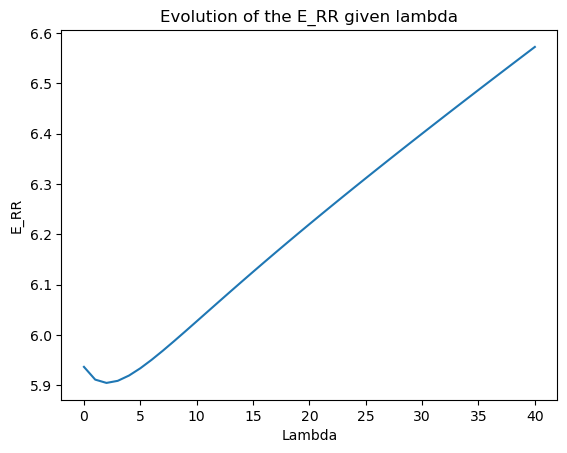

In [88]:
# Exercise 4 FIGURE
plt.plot(list(lambda_pos),results)
plt.ylabel("E_RR")
plt.xlabel("Lambda")
plt.title("Evolution of the E_RR given lambda")
plt.show()

**Résultat à vérifier** : On constate que l'on a un minimum pour lambda = 2 ce qui siginifie que le modèle des moindres carrés régularisés s'avère être moins efficace pour prédire la réalité que le modèle des moindres carrés avec sélection des attributs.

In [ ]:
# Exercise 4 (continued)